## Feature Engineering

This notebook takes the raw clinical data and builds corresponding features. There are a mix of continuous and categorical variables from the clinical data, and some contain more missing values than others. 

The general strategy is to window the data into 10 hour blocks, with a one hour prediction of sepsis/no sepsis. For each window, the following variables are retained as time series:
<br />-HR
<br />-MAP
<br />-O2Sat
<br />-SBP
<br />-Resp

The remainder of the variables are summarized as a single value, the median of the ten values in that window. This is a strategy to deal with the fact that there may be > 90% missing data for some variables.




Import libraries

In [31]:
import pandas as pd
import numpy as np
import pdb
import os
import shutil
import warnings

# from google_drive_downloader import GoogleDriveDownloader as gdd

Create the feats folder, or remove it if it exists

In [32]:
try:
    if os.path.exists('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h'):
        shutil.rmtree('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h')
    os.makedirs('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h')
except Exception as e:
    print(e)

Download the data

In [33]:
# #the link to download combined.pkl
# file_id = '1AmIJQ2oo7Cy1w32T8d1v-rXiJKM0wZE-'

# #load in the data and labels
# gdd.download_file_from_google_drive(file_id=file_id, dest_path='./combined.pkl')

df1 = pd.read_pickle('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/combined_mimic_nosepsis.pkl')
unique_p = df1['patient'].unique()
selected_patient = unique_p[:3000]
df_nosepsis = df1[df1['patient'].isin(selected_patient)]

df2 = pd.read_pickle('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/combined_mimic.pkl')

df = pd.concat([df_nosepsis,df2],ignore_index=True)



In [34]:
df1

,HR,MAP,O2Sat,SBP,Resp,Gender,age,DBP,Temp,Glucose,...,Chloride,HCO3,Phosphate,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,SepsisLabel,patient
0,91.0,80.0,NaN,84.0,24.0,0.0,52.0,48.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
1,94.0,80.0,97.0,88.0,23.0,0.0,52.0,56.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
2,105.0,80.0,94.0,91.0,21.0,0.0,52.0,55.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
3,97.0,80.0,95.0,95.0,20.0,0.0,52.0,58.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
4,100.0,80.0,95.0,86.0,21.0,0.0,52.0,53.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800299,98.0,-1.0,97.0,121.0,22.0,0.0,57.0,72.0,98.599998,100.0,...,114.0,26.0,2.1,31.799999,-1.0,107.0,106.0,1.5,0.0,np022042
800300,98.0,-1.0,97.0,152.0,22.0,0.0,57.0,92.0,98.599998,100.0,...,114.0,26.0,2.1,31.799999,-1.0,107.0,106.0,1.5,0.0,np022042
800301,98.0,-1.0,97.0,152.0,22.0,0.0,57.0,92.0,98.599998,100.0,...,114.0,26.0,2.1,31.799999,-1.0,107.0,106.0,1.5,0.0,np022042
800302,93.0,-1.0,97.0,152.0,20.0,0.0,57.0,92.0,98.599998,100.0,...,114.0,26.0,2.1,31.799999,-1.0,107.0,106.0,1.5,0.0,np022042


In [35]:
df2

,HR,MAP,O2Sat,SBP,Resp,Gender,age,DBP,Temp,Glucose,...,Chloride,HCO3,Phosphate,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,SepsisLabel,patient
0,114.0,-1.0,100.0,NaN,32.0,1.0,52.0,NaN,94.599998,NaN,...,NaN,NaN,NaN,NaN,11.9,NaN,NaN,NaN,0.0,p00
1,105.0,-1.0,100.0,126.0,25.0,1.0,52.0,73.0,94.599998,NaN,...,NaN,NaN,NaN,NaN,11.9,NaN,NaN,NaN,0.0,p00
2,114.0,-1.0,100.0,118.0,26.0,1.0,52.0,65.0,98.400002,NaN,...,NaN,NaN,NaN,NaN,11.9,NaN,NaN,NaN,1.0,p00
3,114.0,-1.0,100.0,118.0,26.0,1.0,52.0,65.0,98.400002,254.0,...,109.0,12.0,8.7,NaN,12.0,NaN,NaN,NaN,1.0,p00
4,91.0,-1.0,100.0,118.0,25.0,1.0,52.0,65.0,94.500000,254.0,...,109.0,12.0,8.7,NaN,11.8,NaN,NaN,NaN,1.0,p00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95555,79.0,-1.0,99.0,109.0,13.0,1.0,56.0,78.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
95556,81.0,-1.0,100.0,110.0,14.0,1.0,56.0,71.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
95557,75.0,-1.0,99.0,97.0,13.0,1.0,56.0,65.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
95558,78.0,-1.0,99.0,100.0,14.0,1.0,56.0,62.0,97.900002,159.0,...,103.0,19.0,1.8,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829


In [36]:
df

,HR,MAP,O2Sat,SBP,Resp,Gender,age,DBP,Temp,Glucose,...,Chloride,HCO3,Phosphate,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,SepsisLabel,patient
0,91.0,80.0,NaN,84.0,24.0,0.0,52.0,48.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
1,94.0,80.0,97.0,88.0,23.0,0.0,52.0,56.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
2,105.0,80.0,94.0,91.0,21.0,0.0,52.0,55.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
3,97.0,80.0,95.0,95.0,20.0,0.0,52.0,58.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
4,100.0,80.0,95.0,86.0,21.0,0.0,52.0,53.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203882,79.0,-1.0,99.0,109.0,13.0,1.0,56.0,78.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203883,81.0,-1.0,100.0,110.0,14.0,1.0,56.0,71.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203884,75.0,-1.0,99.0,97.0,13.0,1.0,56.0,65.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203885,78.0,-1.0,99.0,100.0,14.0,1.0,56.0,62.0,97.900002,159.0,...,103.0,19.0,1.8,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203887 entries, 0 to 203886
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   HR               203887 non-null  float64
 1   MAP              203887 non-null  float64
 2   O2Sat            202039 non-null  float64
 3   SBP              185406 non-null  float64
 4   Resp             202963 non-null  float64
 5   Gender           203887 non-null  float64
 6   age              203887 non-null  float64
 7   DBP              185395 non-null  float64
 8   Temp             194660 non-null  float64
 9   Glucose          185132 non-null  float64
 10  Potassium        186718 non-null  float64
 11  Hct              187269 non-null  float64
 12  Hgb              181207 non-null  float64
 13  pH               190374 non-null  float64
 14  WBC              180886 non-null  float64
 15  Magnesium        177306 non-null  float64
 16  Creatinine       187531 non-null  floa

In [38]:
df

,HR,MAP,O2Sat,SBP,Resp,Gender,age,DBP,Temp,Glucose,...,Chloride,HCO3,Phosphate,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,SepsisLabel,patient
0,91.0,80.0,NaN,84.0,24.0,0.0,52.0,48.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
1,94.0,80.0,97.0,88.0,23.0,0.0,52.0,56.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
2,105.0,80.0,94.0,91.0,21.0,0.0,52.0,55.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
3,97.0,80.0,95.0,95.0,20.0,0.0,52.0,58.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
4,100.0,80.0,95.0,86.0,21.0,0.0,52.0,53.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203882,79.0,-1.0,99.0,109.0,13.0,1.0,56.0,78.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203883,81.0,-1.0,100.0,110.0,14.0,1.0,56.0,71.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203884,75.0,-1.0,99.0,97.0,13.0,1.0,56.0,65.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203885,78.0,-1.0,99.0,100.0,14.0,1.0,56.0,62.0,97.900002,159.0,...,103.0,19.0,1.8,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829


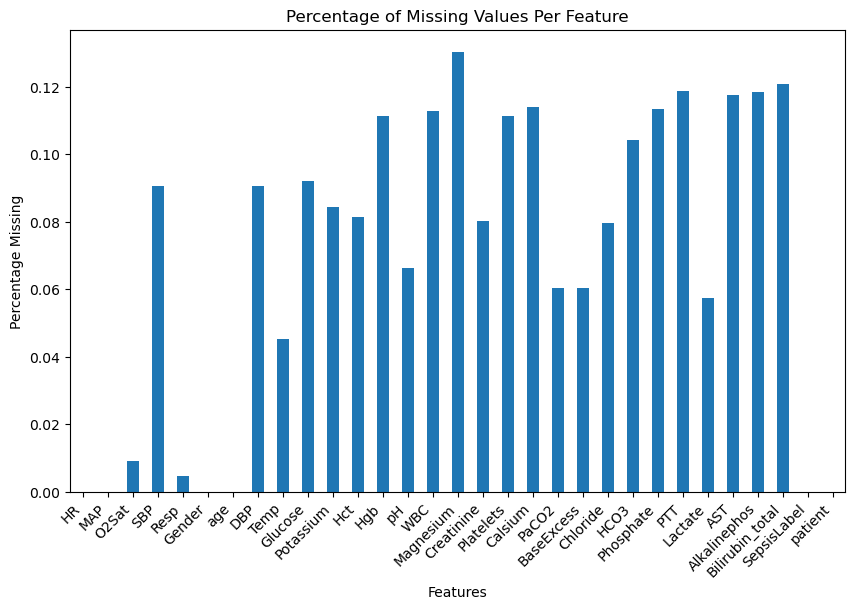

In [39]:
import pandas as pd
import matplotlib.pyplot as plt


missing_percentage = df.isna().sum() / len(df)


plt.figure(figsize=(10, 6)) 
missing_percentage.plot(kind='bar')  
plt.title('Percentage of Missing Values Per Feature')  
plt.xlabel('Features')  
plt.ylabel('Percentage Missing')  
plt.xticks(rotation=45, ha="right")  
plt.show()


Set up the columns

In [40]:
#get the percentage missing for each column
print('Percentage Missing:')
print(df.isna().sum()/len(df))

#columns to drop
#drop Unit2 because Unit1 and Unit2 are mutually exclusive
#drop ICULOS as it's basically just an index
# cols_to_drop = ['Unit2', 'ICULOS']
# df = df.drop(cols_to_drop, axis=1)

#columns with < 15% missing data, and continuous data. these will be retained as time series
cols_cont = ['HR', 'MAP', 'O2Sat', 'SBP', 'Resp']

#columns with continuous data and > 15% missing data
columns = df.columns.tolist()
columns_to_exclude = ['patient','SepsisLabel']#,'HR', 'MAP', 'O2Sat', 'SBP', 'Resp']
cols_to_bin = [col for col in columns if col not in columns_to_exclude]


Percentage Missing:
HR                 0.000000
MAP                0.000000
O2Sat              0.009064
SBP                0.090643
Resp               0.004532
Gender             0.000000
age                0.000000
DBP                0.090697
Temp               0.045255
Glucose            0.091987
Potassium          0.084208
Hct                0.081506
Hgb                0.111238
pH                 0.066277
WBC                0.112812
Magnesium          0.130371
Creatinine         0.080221
Platelets          0.111174
Calsium            0.114044
PaCO2              0.060455
BaseExcess         0.060455
Chloride           0.079505
HCO3               0.104195
Phosphate          0.113381
PTT                0.118678
Lactate            0.057399
AST                0.117629
Alkalinephos       0.118556
Bilirubin_total    0.120846
SepsisLabel        0.000000
patient            0.000000
dtype: float64


In [41]:
cols_to_bin

['HR',
 'MAP',
 'O2Sat',
 'SBP',
 'Resp',
 'Gender',
 'age',
 'DBP',
 'Temp',
 'Glucose',
 'Potassium',
 'Hct',
 'Hgb',
 'pH',
 'WBC',
 'Magnesium',
 'Creatinine',
 'Platelets',
 'Calsium',
 'PaCO2',
 'BaseExcess',
 'Chloride',
 'HCO3',
 'Phosphate',
 'PTT',
 'Lactate',
 'AST',
 'Alkalinephos',
 'Bilirubin_total']

Calculate the mean/std for standardization for each variable. Leave out a random 8000 patients as the test set. In other words don't include a random 4000 patients when calculating the mean/std scaling parameters.

In [42]:
patients_training_data = df['patient'].unique()
len(patients_training_data)

4830

In [43]:
patients_training_data = df['patient'].unique()
np.random.shuffle(patients_training_data)
patients_training_data = patients_training_data[0:-800]

df_mean_std = df[df['patient'].isin(patients_training_data)].describe().loc[['mean', 'std']]
df_mean_std.to_pickle('mean_std_scaling_mimic.pkl')

In [44]:
df_mean_std

,HR,MAP,O2Sat,SBP,Resp,Gender,age,DBP,Temp,Glucose,...,BaseExcess,Chloride,HCO3,Phosphate,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,SepsisLabel
mean,83.462441,54.064036,96.517361,119.929806,19.011904,0.556265,64.494902,65.313529,97.069354,133.925125,...,-0.799729,103.713896,23.693021,3.432452,31.807560,0.738284,115.812261,57.767702,0.402990,0.413101
std,17.798901,47.061997,23.518955,305.952803,5.634484,0.496826,17.716246,232.290100,12.965097,54.308430,...,3.389347,7.145750,4.656880,1.324584,23.127143,1.935179,711.675366,102.771443,3.088867,0.492392


In [45]:
df_mean_std.isnull().values.any()

False

In [46]:
len(patients_training_data), len(df['patient'].unique())

(4030, 4830)

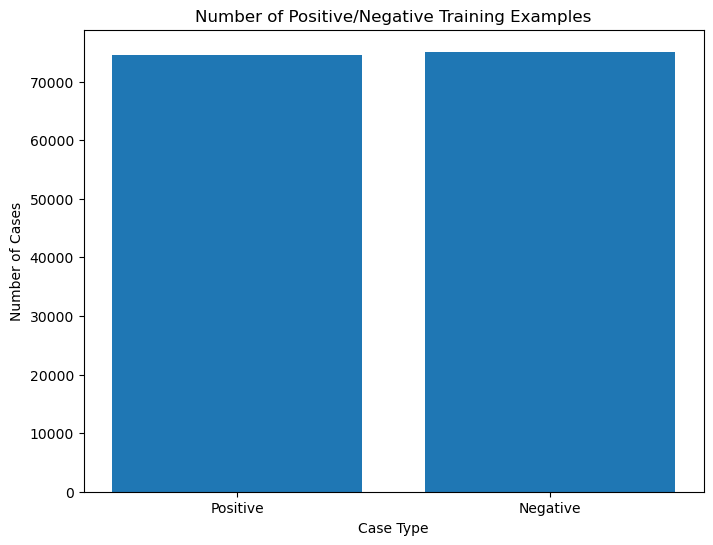

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 是你的 DataFrame
# 假设 patients_training_data 是训练数据中病人的列表
# 计算阳性和阴性案例的数量
positive_cases = 74535
negative_cases = 75104

# 准备用于绘图的数据
cases = {'Positive': positive_cases, 'Negative': negative_cases}

# 绘制柱状图
plt.figure(figsize=(8, 6))  # 设置图表大小
plt.bar(cases.keys(), cases.values())  # 绘制柱状图
plt.title('Number of Positive/Negative Training Examples')  # 设置标题
plt.xlabel('Case Type')  # 设置x轴标签
plt.ylabel('Number of Cases')  # 设置y轴标签
plt.show()


In [48]:
print('Number of positive/negative training examples:')
sum(df[df['patient'].isin(patients_training_data)]['SepsisLabel']==1), sum(df[df['patient'].isin(patients_training_data)]['SepsisLabel']==0)

Number of positive/negative training examples:


(70014, 99470)

In [49]:
df

,HR,MAP,O2Sat,SBP,Resp,Gender,age,DBP,Temp,Glucose,...,Chloride,HCO3,Phosphate,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,SepsisLabel,patient
0,91.0,80.0,NaN,84.0,24.0,0.0,52.0,48.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
1,94.0,80.0,97.0,88.0,23.0,0.0,52.0,56.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
2,105.0,80.0,94.0,91.0,21.0,0.0,52.0,55.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
3,97.0,80.0,95.0,95.0,20.0,0.0,52.0,58.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
4,100.0,80.0,95.0,86.0,21.0,0.0,52.0,53.0,98.699997,NaN,...,NaN,NaN,NaN,-1.000000,-1.0,NaN,NaN,NaN,0.0,np00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203882,79.0,-1.0,99.0,109.0,13.0,1.0,56.0,78.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203883,81.0,-1.0,100.0,110.0,14.0,1.0,56.0,71.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203884,75.0,-1.0,99.0,97.0,13.0,1.0,56.0,65.0,98.099998,174.0,...,100.0,23.0,1.3,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829
203885,78.0,-1.0,99.0,100.0,14.0,1.0,56.0,62.0,97.900002,159.0,...,103.0,19.0,1.8,32.200001,-1.0,71.0,306.0,10.5,1.0,p01829


Loop through each subject and grab a window of 10 hours, with an output label associated with the 11th hour (ie predict one hour ahead). Note that you will need to create a directory called "feats" for this to run.

In [50]:
#loop through each patient at a time
save_count = 0
windowed_df_list = []
grouped_by_patient = df.groupby('patient')
num = 0
for patient, group in grouped_by_patient:
    num += 1
    # print(patient)
    group = group.reset_index(drop=True)

    #backfill any missing values for the continuous variables with < 15% missing data
    # group = group.assign(HR=group['HR'].fillna(method='bfill').fillna(method='ffill'))
    # group = group.assign(MAP=group['MAP'].fillna(method='bfill').fillna(method='ffill'))
    # group = group.assign(O2Sat=group['O2Sat'].fillna(method='bfill').fillna(method='ffill'))
    # group = group.assign(SBP=group['SBP'].fillna(method='bfill').fillna(method='ffill'))
    # group = group.assign(Resp=group['Resp'].fillna(method='bfill').fillna(method='ffill'))
    
    # forward fill 
    # 时序数据 没有
    group = group.assign(HR=group['HR'].ffill().bfill())
    group = group.assign(MAP=group['MAP'].ffill().bfill())
    group = group.assign(O2Sat=group['O2Sat'].ffill().bfill())
    group = group.assign(SBP=group['SBP'].ffill().bfill())
    group = group.assign(Resp=group['Resp'].ffill().bfill())
    
    # bin data
    # 普通数据 很多缺失
    for col in cols_to_bin:
        group = group.assign(**{col: group[col].ffill().bfill()}) #
    
    
    # standardize the continous data
    group = group.assign(HR=(group['HR']-df_mean_std['HR']['mean'])/(df_mean_std['HR']['std']))
    group = group.assign(MAP=(group['MAP']-df_mean_std['MAP']['mean'])/(df_mean_std['MAP']['std']))
    group = group.assign(O2Sat=(group['O2Sat']-df_mean_std['O2Sat']['mean'])/(df_mean_std['O2Sat']['std']))
    group = group.assign(SBP=(group['SBP']-df_mean_std['SBP']['mean'])/(df_mean_std['SBP']['std']))
    group = group.assign(Resp=(group['Resp']-df_mean_std['Resp']['mean'])/(df_mean_std['Resp']['std']))

    #generate windows of 10 hours, predicting one sample into the future
    windowed_data = []
    N = len(group)
    win_len = 10
    pred_len = 1 # 10h data predict 11th sepsis or not
    
    # detection
    win_len = 2
    pred_len = 1 # detection这里也要设置为1
    
    i = 0
    while(i+win_len+pred_len <= N):
        tmp_data = group.iloc[i:i+win_len]
        tmp_label = group.iloc[i+win_len:i+win_len+pred_len]
        tmp_label = int(any(tmp_label['SepsisLabel']))
        tmp_patient = patient

        #slide the window forward
        i = i+1

        #get all the continuous variables into one group
        X_cont = tmp_data[cols_cont]
        X_cont = X_cont.values

        #if any of the continuous variables is nan (in other words, there wasn't even a single value to 
        #backfill/forwardfill) then just skip this window
        if np.isnan(X_cont).any(): continue

        #process each of the variables to be binned
        X_binned_dict = {}
        for col_to_bin in cols_to_bin:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                tmp_val = tmp_data[col_to_bin].median() # insight
            if col_to_bin not in ['Gender', 'Unit1']:
                tmp_val = (tmp_val-df_mean_std[col_to_bin]['mean'])/df_mean_std[col_to_bin]['std']
                
            X_binned_dict[col_to_bin] = tmp_val
        
        #package it all into a dictionary
        tmp_dict = X_binned_dict
        tmp_dict['X_cont'] = X_cont
        tmp_dict['label'] = tmp_label
        tmp_dict['patient'] = tmp_patient
        windowed_data.append(tmp_dict)
        
    #append the dataframe to the list of dataframes
    windowed_data_df = pd.DataFrame(windowed_data)
    windowed_df_list.append(windowed_data_df)

    #periodically save every 500 patients
    if (num % 500) == 0:
        print('patient %i' % int(num))
        windowed_df = pd.concat(windowed_df_list).reset_index(drop=True)
        train = windowed_df[windowed_df['patient'].isin(patients_training_data)].drop('patient', axis=1)
        test = windowed_df[~windowed_df['patient'].isin(patients_training_data)].drop('patient', axis=1)

        train.to_pickle('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h/train_%i.pkl' % save_count)
        test.to_pickle('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h/test_%i.pkl' % save_count)

        windowed_df_list = []
        save_count = save_count+1

#save any remaining data
if len(windowed_df_list) > 0:
    print('*******')
    print(len(windowed_df_list))
    #separate the training and testing data
    windowed_df = pd.concat(windowed_df_list).reset_index(drop=True)
    train = windowed_df[windowed_df['patient'].isin(patients_training_data)].drop('patient', axis=1)
    test = windowed_df[~windowed_df['patient'].isin(patients_training_data)].drop('patient', axis=1)

    train.to_pickle('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h/train_%i.pkl' % save_count)
    test.to_pickle('/Users/zhaoxiuheng/Desktop/课程/mlsp/project/code/sepsis_LSTM_multimodal_lhl/feats_mimic_2h/test_%i.pkl' % save_count)



patient 500
patient 1000
patient 1500
patient 2000
patient 2500
patient 3000
patient 3500
patient 4000
patient 4500
*******
330
